In [111]:
import yfinance as yf
import requests
import pandas as pd
import talib
import seaborn as sns


class DataFetcher:
    """Fetch equities and currency data from Yahoo Finance or Alpha Vantage."""
    
    def __init__(self, start_date, end_date, tickers, api_key=None):
        self.start_date = start_date
        self.end_date = end_date
        self.tickers = tickers
        self.api_key = api_key

    def fetch_equities_daily(self):
        """Fetch daily equity data from Yahoo Finance."""
        return {ticker: yf.download(ticker, start=self.start_date, end=self.end_date).drop(columns=['Volume'], errors='ignore') for ticker in self.tickers}

    def fetch_currency_yahoo(self):
        """Fetch 1-hour currency data from Yahoo Finance."""
        return {ticker: yf.download(ticker, start=self.start_date, end=self.end_date, interval='1h').drop(columns=['Volume'], errors='ignore') for ticker in self.tickers}

    def fetch_currency_alphavantage(self):
        """Fetch 1-hour currency data from Alpha Vantage."""
        if not self.api_key:
            raise ValueError("API key required for Alpha Vantage.")
        
        base_url = "https://www.alphavantage.co/query"
        result = {}
        for ticker in self.tickers:
            params = {
                "function": "TIME_SERIES_INTRADAY", "symbol": ticker, "interval": "60min",
                "apikey": self.api_key, "outputsize": "compact", "datatype": "json"
            }
            response = requests.get(base_url, params=params).json()
            if "Time Series (60min)" in response:
                df = pd.DataFrame.from_dict(response["Time Series (60min)"], orient="index").rename(
                    columns={"1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. volume": "Volume"})
                df.index = pd.to_datetime(df.index)
                result[ticker] = df.astype(float)
            else:
                print(f"Error fetching {ticker}: {response.get('Error Message', 'Unknown error')}")
        return result


In [35]:
def make_macd_indicators(data, fast_period=12, slow_period=26, signal_period=9):
    data = data.copy()
    data['MACD'], data['Signal'], data['Hist'] = talib.MACD(
        data['Close'], 
        fastperiod=fast_period, 
        slowperiod=slow_period, 
        signalperiod=signal_period
    )
    return data

class MACDStrategy(Strategy):
    fast_period = 12
    slow_period = 26
    signal_period = 9

    def init(self):
        self.data = make_macd_indicators(
            self.data, 
            fast_period=self.fast_period, 
            slow_period=self.slow_period, 
            signal_period=self.signal_period
        )
        self.macd = self.I(lambda: self.data['MACD'])
        self.signal = self.I(lambda: self.data['Signal'])

    def next(self):
        # Buy when MACD crosses above the Signal line
        if self.macd[-1] > self.signal[-1] and self.macd[-2] <= self.signal[-2]:
            self.buy()
        # Sell when MACD crosses below the Signal line
        elif self.macd[-1] < self.signal[-1] and self.macd[-2] >= self.signal[-2]:
            self.position.close()


In [51]:
def add_cagr_to_stats(stats, cash):
    days = stats['Duration'].days
    years = days / 365.25
    if years > 0:
        cagr = (stats["Equity Final [$]"] / cash) ** (1 / years) - 1
        stats['CAGR (%)'] = cagr * 100
    else:
        stats['CAGR (%)'] = 0
    return stats


def execute_macd_strategy(data, MACDStrategy, fast_period=12, slow_period=26, signal_period=9, 
                          cash=10**5, commission=0.001, exclusive_orders=True):
    strategy = MACDStrategy
    strategy.fast_period = fast_period
    strategy.slow_period = slow_period
    strategy.signal_period = signal_period
    strategy.data = data
    bt = Backtest(data, strategy, cash=cash, commission=commission, exclusive_orders=exclusive_orders)
    stats = bt.run()
    stats = add_cagr_to_stats(stats, cash)
    return stats


In [129]:
def optimize_macd_strategy(data, MACDStrategy, fast_periods, slow_periods, signal_periods, metric):
    strategy = MACDStrategy
    strategy.data = data
    bt = Backtest(data, strategy, cash=10**5, commission=0.000, exclusive_orders=True)
    stats, heatmap = bt.optimize(
        fast_period=fast_periods, 
        slow_period=slow_periods, 
        signal_period=signal_periods,
        maximize=metric, 
        method='grid', 
        max_tries=100, 
        return_heatmap=True
    )
    return stats, heatmap

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy

# Read data
start_date = "2000-01-01"
end_date = "2020-12-11"

tickers = ["SPY"]
data_obj = DataFetcher(start_date, end_date, tickers)
snp_df = data_obj.fetch_equities_daily()

[*********************100%***********************]  1 of 1 completed


Start                     2000-01-03 00:00:00
End                       2020-12-10 00:00:00
Duration                   7647 days 00:00:00
Exposure Time [%]                   55.199241
Equity Final [$]                232929.509735
Equity Peak [$]                 235987.121399
Return [%]                          132.92951
Buy & Hold Return [%]              152.156432
Return (Ann.) [%]                    4.126167
Volatility (Ann.) [%]                12.20928
Sharpe Ratio                         0.337953
Sortino Ratio                        0.507705
Calmar Ratio                         0.141912
Max. Drawdown [%]                  -29.075523
Avg. Drawdown [%]                   -2.046006
Max. Drawdown Duration     2747 days 00:00:00
Avg. Drawdown Duration       79 days 00:00:00
# Trades                                  240
Win Rate [%]                        44.166667
Best Trade [%]                      16.648301
Worst Trade [%]                     -9.192701
Avg. Trade [%]                    

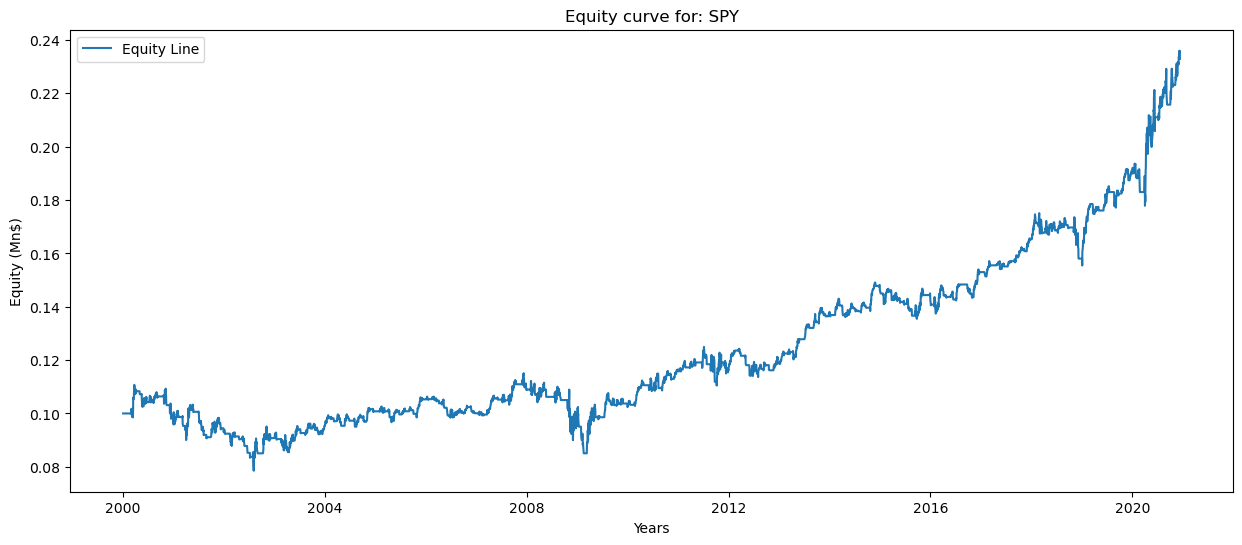

In [152]:
for ticker, data in snp_df.items():
    stats = execute_macd_strategy(
        data=data, 
        MACDStrategy=MACDStrategy, 
        fast_period=17, 
        slow_period=26, 
        signal_period=5,
        commission=0, 
    )
    print(stats)

    plt.figure(figsize=(15, 6))
    # convert x-axis to log scale
    plt.plot(stats._equity_curve.index, (stats._equity_curve['Equity'])/1e6,
             label='Equity Line')
    plt.title('Equity curve for: ' + ticker)
    plt.xlabel('Years')
    plt.ylabel('Equity (Mn$)')
    plt.legend()
    plt.show()
    

In [159]:
fast_periods = range(5, 50)       
slow_periods = range(5, 50)   
signal_periods = range(5, 50)  
metric = 'Sharpe Ratio'        

macd_optimized_stats, macd_heatmap = optimize_macd_strategy(
    data=snp_df['SPY'], 
    MACDStrategy=MACDStrategy, 
    fast_periods=fast_periods, 
    slow_periods=slow_periods, 
    signal_periods=signal_periods, 
    metric=metric
)
print(macd_optimized_stats)

/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/9 [00:00<?, ?it/s]

Start                     2000-01-03 00:00:00
End                       2020-12-10 00:00:00
Duration                   7647 days 00:00:00
Exposure Time [%]                   54.819734
Equity Final [$]                213964.180672
Equity Peak [$]                 216772.191383
Return [%]                         113.964181
Buy & Hold Return [%]              152.156432
Return (Ann.) [%]                    3.704164
Volatility (Ann.) [%]               12.098325
Sharpe Ratio                         0.306172
Sortino Ratio                        0.456076
Calmar Ratio                         0.138489
Max. Drawdown [%]                  -26.746966
Avg. Drawdown [%]                   -2.202637
Max. Drawdown Duration     2734 days 00:00:00
Avg. Drawdown Duration       91 days 00:00:00
# Trades                                  226
Win Rate [%]                         43.80531
Best Trade [%]                      11.445858
Worst Trade [%]                     -9.192701
Avg. Trade [%]                    

In [160]:
macd_optimized_stats._strategy

<Strategy MACDStrategy(fast_period=14,slow_period=7,signal_period=27)>

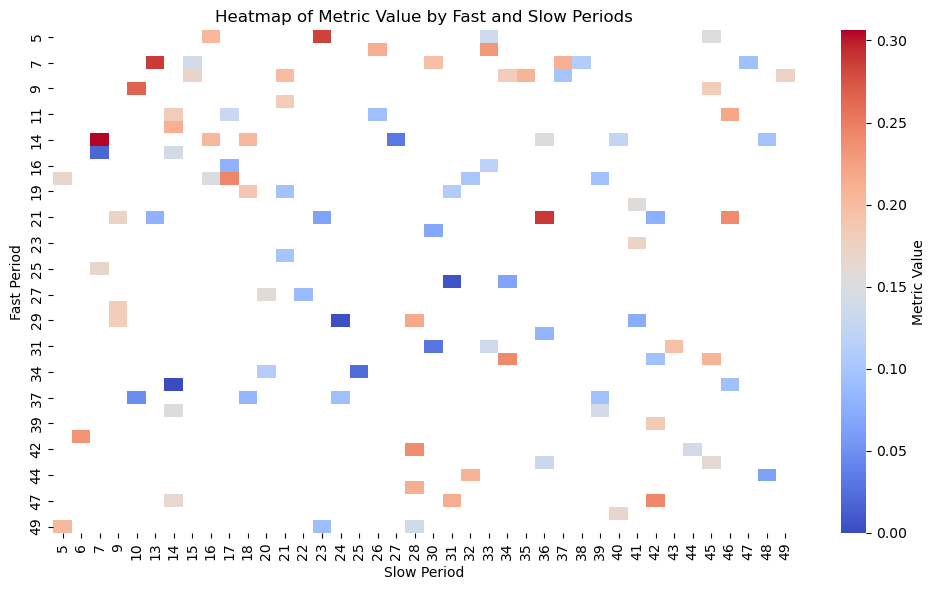

In [163]:
# Pivot the data for heatmap
temp_df = pd.DataFrame(macd_heatmap).reset_index()
heatmap_data = temp_df.pivot_table(
    index="fast_period", 
    columns="slow_period", 
    values="Sharpe Ratio"
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'label': 'Metric Value'}
)

plt.title("Heatmap of Metric Value by Fast and Slow Periods")
plt.xlabel("Slow Period")
plt.ylabel("Fast Period")
plt.tight_layout()
plt.show()

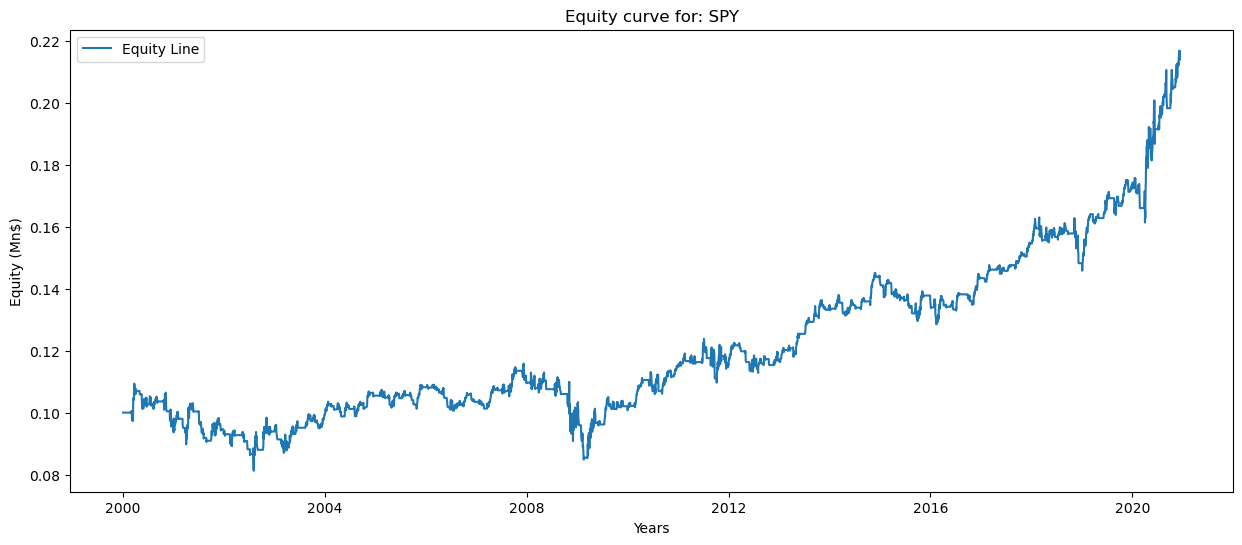

In [165]:
plt.figure(figsize=(15, 6))
# convert x-axis to log scale
plt.plot(macd_optimized_stats._equity_curve.index, (macd_optimized_stats._equity_curve['Equity'])/1e6,
         label='Equity Line')
plt.title('Equity curve for: ' + ticker)
plt.xlabel('Years')
plt.ylabel('Equity (Mn$)')
plt.legend()
plt.show()